# Example for using `neuralib.argp`

- Generating results with flexible options
- Type annotated and simple validator for management
- Structural class inheritances fallowed by experimental logic
- CLI-based for easier run pipeline on server

In [1]:
from typing import ClassVar

import numpy as np
from matplotlib import pyplot as plt

from neuralib.argp import AbstractParser, argument, int_tuple_type
from neuralib.util.verbose import fprint

## Create a common base class for data information

In [2]:
from pathlib import Path
from typing import Literal


class BaseOptions:
    GROUP_BASE: ClassVar = 'Base Options for the Data'

    date: str = argument(
        '-D', '--date',
        metavar='YYMMDD',
        required=True,
        group=GROUP_BASE,
        help='experimental date'
    )

    animal: str = argument(
        '-A', '--animal',
        metavar='NAME',
        required=True,
        group=GROUP_BASE,
        help='animal(mouse) id'
    )

    recording: Literal['ephys', 'wfield', '2P'] = argument(
        '-R', '--recording',
        metavar='DATA_TYPE',
        default='two_photon',
        group=GROUP_BASE,
        help='recording type'
    )

    data_source: Literal['local', 'mnt_server1'] = argument(
        '--src',
        metavar='PATH',
        default='local',
        group=GROUP_BASE,
        help='Path for the data source'
    )

    @property
    def data_path(self) -> Path:
        filename = f'{self.date}_{self.animal}_{self.recording}'
        if self.data_source == 'local':
            return Path('/Users/foo/data') / filename
        elif self.data_source == 'mnt_server':
            return Path('/mnt/mnt_server1') / filename
        else:
            raise NotImplementedError('')

## Create a class for the Two-photon Calcium imaging

In [3]:
class TwoPhotonOptions:
    GROUP_2P: ClassVar = 'Options for the two-photon calcium imaging'

    optic_plane: int = argument(
        '-P', '--optic_plane',
        metavar='INDEX',
        gt=0, lt=5,  # use validate options
        group=GROUP_2P,
        help='optic_plane for volumetric scanning, from 1 to 4'
    )

    neuron_id: int | None = argument(
        '-N', '--neuron-id',
        type=int,
        default=None,
        group=GROUP_2P,
        help='neuron id'
    )

## Create a class for the Behavioral options

In [4]:
class BehavioralOptions:
    GROUP_BEHAVIOR: ClassVar = 'Options for the behavioral task'

    running_epoch: bool = argument(
        '--running',
        group=GROUP_BEHAVIOR,
        help='whether only use running epoch'
    )

    smooth_kernel: int | None = argument(
        '--smooth-kernel',
        metavar='KERNEL',
        type=int,
        default=None,
        group=GROUP_BEHAVIOR,
        help='kernel size for smooth running speed'
    )

    remove_backward: bool = argument(
        '--no-backward',
        group=GROUP_BEHAVIOR,
        help='whether to remove the backward running'
    )

## Create the main run class for generating your figures

In [5]:
class ExamplePlotRunningOptions(AbstractParser, BaseOptions, TwoPhotonOptions, BehavioralOptions):
    DESCRIPTION = 'Plot for running versus two-photon signals'

    time_interval: tuple[int, int] | None = argument(
        '--time',
        metavar='SECONDS',
        type=int_tuple_type,
        default=(0, 100),
        max_length=2,  # validator for not more than 2 elements
        help='time interval (START,END)'
    )

    def run(self):
        """MAIN for run"""
        self.plot()

    def plot(self):
        fprint(f'Now plotting from: {self.data_path}')

        time = np.linspace(0, 1000, 1000)

        # process velocity
        velocity = np.random.rand(1000)
        if self.remove_backward:
            velocity[velocity < 0] = np.nan
        if self.smooth_kernel is not None:
            from scipy.ndimage import gaussian_filter1d
            gaussian_filter1d(velocity, self.smooth_kernel, output=velocity)

        # two-photon signal
        signal_2p = np.random.rand(10, 1000)  # generate (N, T) for 10 neurons

        # time limit
        if self.time_interval is not None:
            x = slice(*self.time_interval)
            time = time[x]
            velocity = velocity[x]
            signal_2p = signal_2p[:, x]

        # plot
        if self.neuron_id is not None:
            _, ax = plt.subplots()
            signal_2p = signal_2p[self.neuron_id, :]
            ax.plot(time, signal_2p, label='calcium signal')
            ax.plot(time, velocity, label='velocity')
            ax.set(xlabel='time(sec)', ylabel='signal')
            ax.set_title(f'neuron: {self.neuron_id}')
            ax.legend()
        else:
            nrow, ncol = 2, 5
            _, ax = plt.subplots(nrow, ncol, figsize=(12, 8))

            for i, sig in enumerate(signal_2p):
                r, c = divmod(i, 5)
                ax[r, c].plot(time, sig)
                ax[r, c].plot(time, velocity)
                ax[r, c].set_title(f'neuron: {i}')
                ax[r, c].axis('off')


### Run example of neuron: 5, and time interval (0,100) with running smoothing
- also run on terminal if in a `.py` script (`python -m MODULE.PATH -D 250101 -A mouse01 ...`)


{'animal': 'mouse01',
 'data_source': 'local',
 'date': '250101',
 'neuron_id': 5,
 'optic_plane': None,
 'recording': '2P',
 'remove_backward': False,
 'running_epoch': False,
 'smooth_kernel': 3,
 'time_interval': (0, 100)}
[INFO][25-03-13 22:09:00] - Now plotting from: /Users/foo/data/250101_mouse01_2P



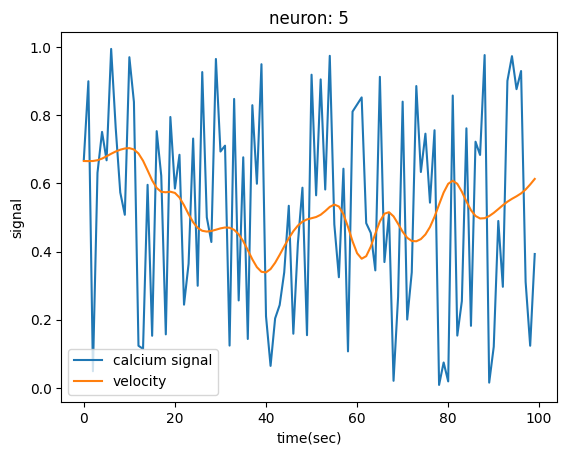

In [6]:
from neuralib.argp import parse_args, as_dict
from pprint import pprint

opt = parse_args(
    ExamplePlotRunningOptions(),
    ['-D', '250101', '-A', 'mouse01', '-R', '2P', '--smooth-kernel', '3', '--neuron-id', '5', '--time', '0,100']
)

pprint(as_dict(opt))  # see options given
opt.run()

### Run example of all neurons, and time interval (100, 200) without smooth

{'animal': 'mouse01',
 'data_source': 'local',
 'date': '250101',
 'neuron_id': None,
 'optic_plane': None,
 'recording': '2P',
 'remove_backward': False,
 'running_epoch': False,
 'smooth_kernel': None,
 'time_interval': (100, 200)}
[INFO][25-03-13 22:09:00] - Now plotting from: /Users/foo/data/250101_mouse01_2P



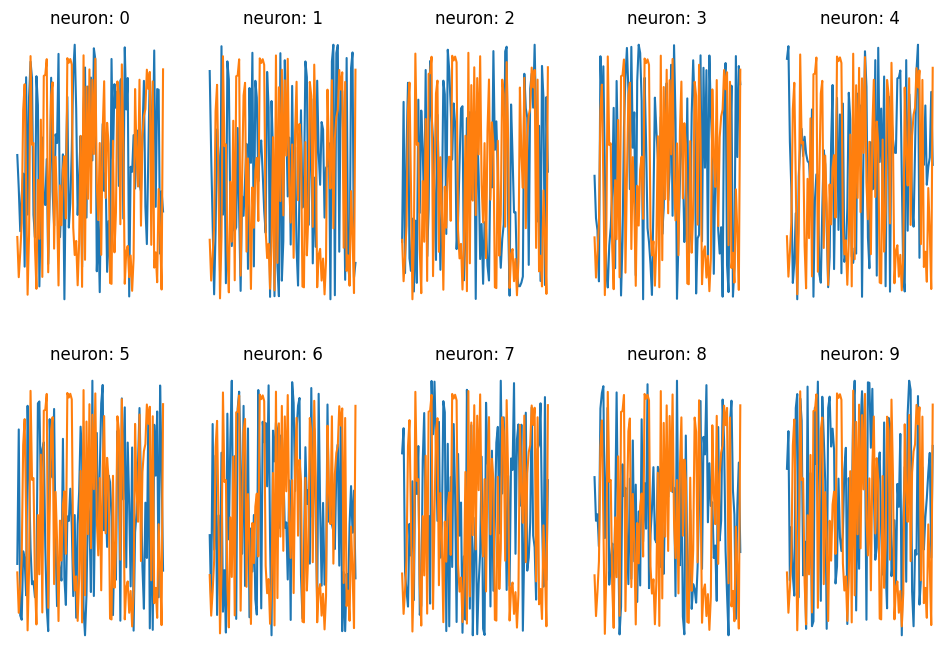

In [7]:
opt = parse_args(
    ExamplePlotRunningOptions(),
    ['-D', '250101', '-A', 'mouse01', '-R', '2P', '--time', '100,200']
)

pprint(as_dict(opt))  # see options given
opt.run()

## Show help message

- also run on terminal if in a `.py` script (`python -m MODULE.PATH -h ...`)

In [8]:
from neuralib.argp import print_help

print_help(opt)

usage: ipykernel_launcher.py [-h] [--time SECONDS] [--running]
                             [--smooth-kernel KERNEL] [--no-backward]
                             [-P INDEX] [-N NEURON_ID] -D YYMMDD -A NAME
                             [-R DATA_TYPE] [--src PATH]

Plot for running versus two-photon signals

options:
  -h, --help            show this help message and exit
  --time SECONDS        time interval (START,END)

Options for the behavioral task:
  --running             whether only use running epoch
  --smooth-kernel KERNEL
                        kernel size for smooth running speed
  --no-backward         whether to remove the backward running

Options for the two-photon calcium imaging:
  -P INDEX, --optic_plane INDEX
                        optic_plane for volumetric scanning, from 1 to 4
  -N NEURON_ID, --neuron-id NEURON_ID
                        neuron id

Base Options for the Data:
  -D YYMMDD, --date YYMMDD
                        experimental date
  -A NAME, --animal 